# Airbnb Prices Berlin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

import seaborn as sns

In [2]:
style.use("fivethirtyeight")

## Load data

In [3]:
listings = pd.read_csv("listings_summary.csv")

In [4]:
listings.shape

(22552, 96)

As there are so many variables, let's select the ones that can be useful to predict price.

In [5]:
# define the columns to keep
column_names=['id', 
       
       'host_id', 
       'host_total_listings_count',  

       'neighbourhood_group_cleansed',  
       'latitude', 'longitude',
              
       'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 
       'amenities',      
              
       'price',  'security_deposit', 'extra_people',
       'cleaning_fee',
        'minimum_nights',
       'maximum_nights', 
       
       'number_of_reviews', 
       'cancellation_policy'
             ]

In [6]:
data = listings[column_names]
print(data.shape)

(22552, 20)


## Data cleaning and preparation

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22552 non-null  int64  
 1   host_id                       22552 non-null  int64  
 2   host_total_listings_count     22526 non-null  float64
 3   neighbourhood_group_cleansed  22552 non-null  object 
 4   latitude                      22552 non-null  float64
 5   longitude                     22552 non-null  float64
 6   property_type                 22552 non-null  object 
 7   room_type                     22552 non-null  object 
 8   accommodates                  22552 non-null  int64  
 9   bathrooms                     22520 non-null  float64
 10  bedrooms                      22534 non-null  float64
 11  amenities                     22552 non-null  object 
 12  price                         22552 non-null  object 
 13  s

First, let's change the format of the price columns to numeric.

In [8]:
data[['price', 'cleaning_fee', 'extra_people','security_deposit']].head(2)

,price,cleaning_fee,extra_people,security_deposit
0,$60.00,$30.00,$28.00,$200.00
1,$17.00,$0.00,$0.00,$0.00


In [9]:
## clean price columns

prices=['price', 'cleaning_fee', 'extra_people', 'security_deposit']

for p in prices:
    data[p]=pd.Series([str(s).replace('$', '').replace(',', '') for s in data[p]]).astype(float)
    

<ipython-input-9-97b1aa2e0d2c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[p]=pd.Series([str(s).replace('$', '').replace(',', '') for s in data[p]]).astype(float)


In [10]:
data[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(2)

,price,cleaning_fee,extra_people,security_deposit
0,60.0,30.0,28.0,200.0
1,17.0,0.0,0.0,0.0


As we have NAs for deposit and cleaning fee, let's fill these fields with 0 (as we can assume that if they are not mentioned there is no charge).

In [11]:
data.security_deposit.fillna(0, inplace=True)
data.cleaning_fee.fillna(0,inplace=True)

/opt/anaconda3/envs/PyEnv/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


There are still a few missing values which can be dropped:

In [12]:
#missing values
data.isnull().sum()

id                               0
host_id                          0
host_total_listings_count       26
neighbourhood_group_cleansed     0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                       32
bedrooms                        18
amenities                        0
price                            0
security_deposit                 0
extra_people                     0
cleaning_fee                     0
minimum_nights                   0
maximum_nights                   0
number_of_reviews                0
cancellation_policy              0
dtype: int64

In [13]:
data.dropna(inplace=True)

<ipython-input-13-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [14]:
data.shape

(22476, 20)

## Exploration

In [15]:
data["price"].describe()
# appears we have some extreme outliers

count    22476.000000
mean        66.794314
std        212.433443
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       8600.000000
Name: price, dtype: float64

For price, it appears that there are some very large outliers (8600 per night seems excessive for an Airbnb). Let's clean this field after looking at the properties included in the dataset.

[(0, 500)]

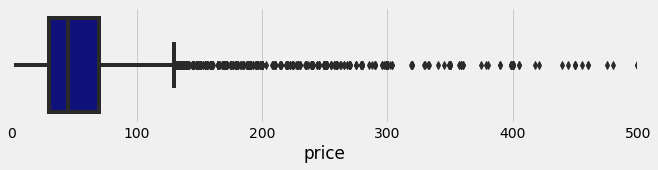

In [16]:
plt.figure(figsize=(10,2))
ax=sns.boxplot(data["price"],color="darkblue")
ax.set(xlim=(0, 500))

### __Property type__

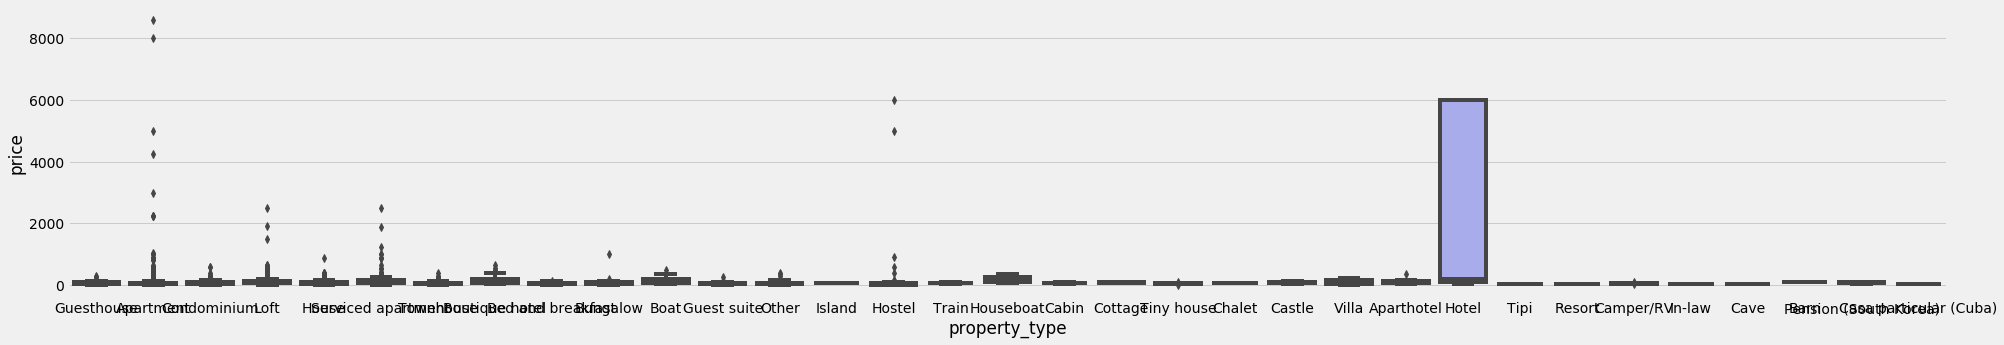

In [17]:
plt.figure(figsize=(30,5))
sns.boxplot(x="property_type",y="price",data=data)

As expected, the prices are very dispersed, and it seems that Hotel prices represent most of the high prices. Looking at the property types, we have 90% apartments, and for the other categories very few observations. I will keep only apartments for modeling to try to build a good model with this data.

In [18]:
data = data[(data['property_type'] == 'Apartment')]
data.drop(['property_type'], axis=1, inplace=True)

Let's remove the price outliers now:

In [19]:
len(data[data["price"]>200])

255

In [20]:
len(data[data["price"]>200])
data=data[data["price"]<200]

len(data[data["price"]==0])
data=data[data["price"]>0] 

### Map of apartments

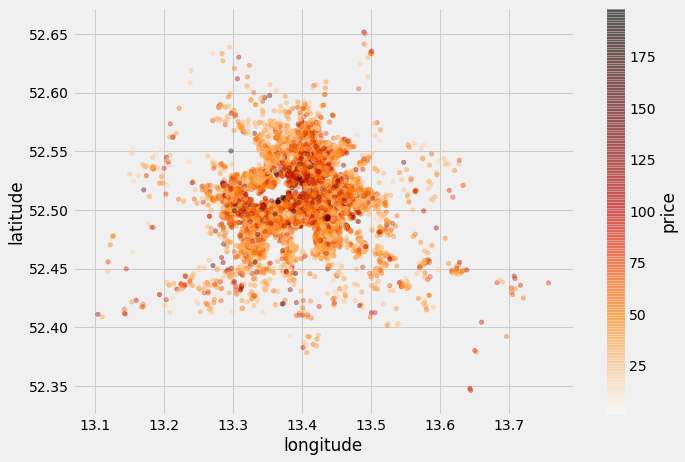

In [21]:
viz1=data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False)

berlin_centre = (52, 13)

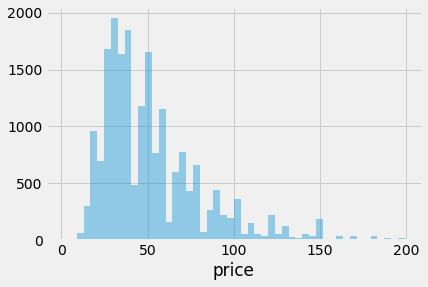

In [22]:
sns.distplot(data["price"],kde=False)

Transforming the price to a log scale improves its distribution only slightly, so I decide to just remove the outliers on the right tail:

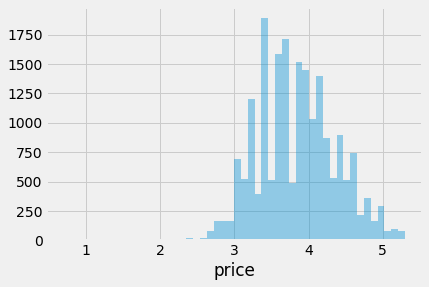

In [23]:
sns.distplot(np.log1p(data["price"]),kde=False)

In [24]:
data=data[data["price"]<160]

In [25]:
data.shape

(19633, 19)

### Neighbourhoods

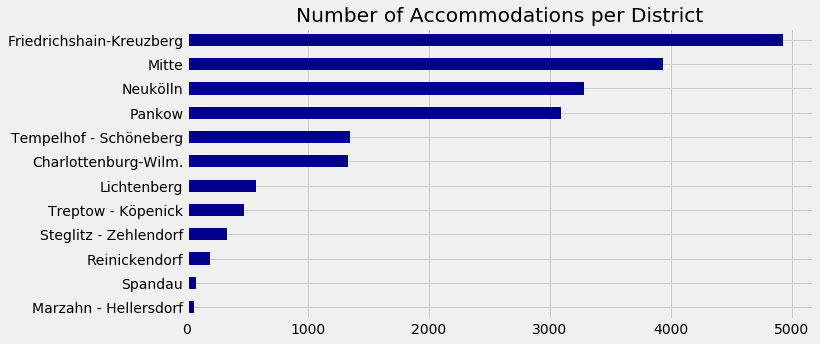

In [26]:
plt.figure(figsize=(10,5))
data['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkblue')
plt.title('Number of Accommodations per District');

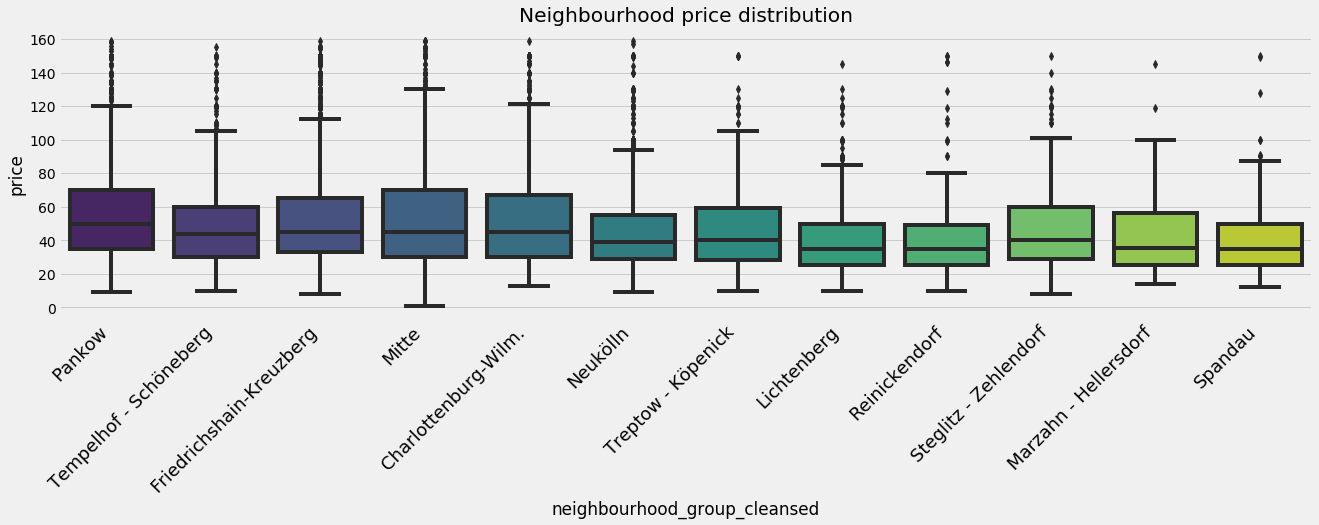

In [27]:
plt.figure(figsize=(20,5))

chart=sns.boxplot(x="neighbourhood_group_cleansed", y="price", data=data, palette="viridis")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=18)
plt.title('Neighbourhood price distribution')
chart

### Bedrooms

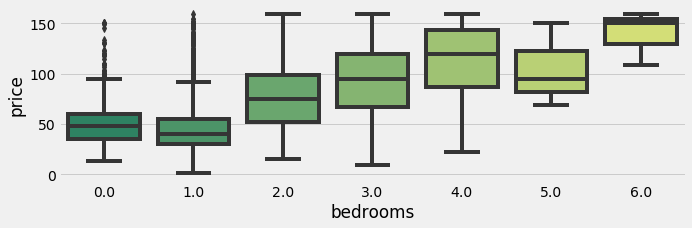

In [28]:
plt.figure(figsize=(10,3))
sns.boxplot(x="bedrooms", y="price", data=data,palette="summer")

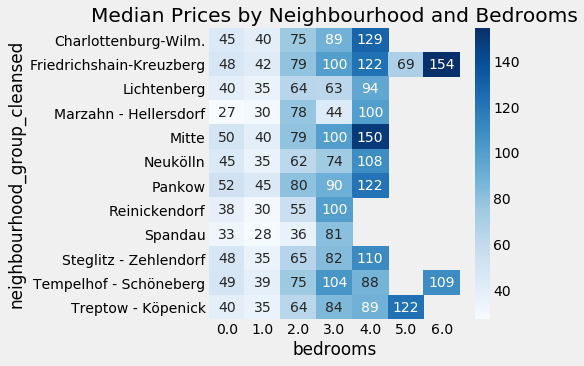

In [29]:
plt.figure(figsize=(5,5))
sns.heatmap(data.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Blues', annot=True, fmt=".0f")
plt.title("Median Prices by Neighbourhood and Bedrooms")
plt.show()

### Cancellation policy

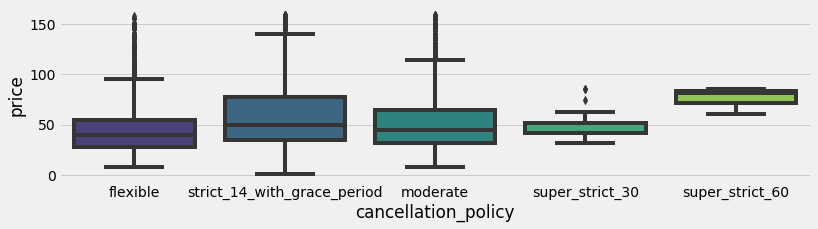

In [30]:
plt.figure(figsize=(12,3))
sns.boxplot(x="cancellation_policy", y="price", data=data, palette='viridis')

In [31]:
data["cancellation_policy"].value_counts()

flexible                       8163
moderate                       6240
strict_14_with_grace_period    5182
super_strict_30                  45
super_strict_60                   3
Name: cancellation_policy, dtype: int64

In [32]:
data = data[(data['cancellation_policy'] == 'flexible') |
            (data['cancellation_policy'] == 'moderate') |
            (data['cancellation_policy'] == 'strict_14_with_grace_period')]

### Bathrooms

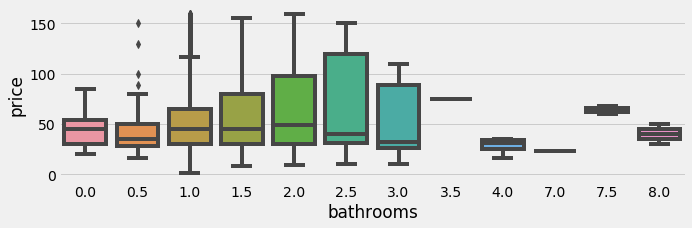

In [33]:
plt.figure(figsize=(10,3))
sns.boxplot(x="bathrooms",y="price",data=data)

In [34]:
# cleaning the outliers
data["bathrooms"].value_counts()
data=data[data["bathrooms"]<=2]


### Amenities

In [35]:
from collections import Counter

In [36]:
amenities = Counter()
data['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(amenities.update)

amenities.most_common(10)

[('Kitchen', 18684),
 ('Wifi', 18664),
 ('Heating', 18343),
 ('Essentials', 17593),
 ('Washer', 16260),
 ('Hair dryer', 12685),
 ('Laptop friendly workspace', 12478),
 ('Hangers', 11664),
 ('Iron', 9392),
 ('Shampoo', 9051)]

In [37]:
# create a new dataframe for plotting
sub_df = pd.DataFrame(amenities.most_common(25), columns=['amenity', 'count'])

<Figure size 720x360 with 0 Axes>

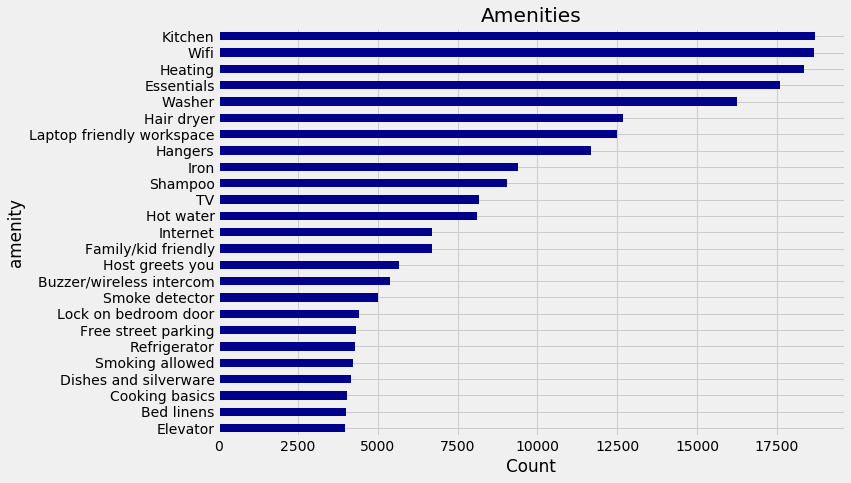

In [38]:
# plot the top amenities
plt.figure(figsize=(10,5))
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color="darkblue",
                                                      title='Amenities')
plt.xlabel('Count');

After some exploration, these amenities seem to lead to different prices, so let's create binary variables out of them.

In [39]:
data['Laptop_friendly_workspace'] = data['amenities'].str.contains('Laptop friendly workspace')
data['TV'] = data['amenities'].str.contains('TV')
data['Hot water']=data['amenities'].str.contains('Hot water')
data['Family_friendly'] = data['amenities'].str.contains('Family/kid friendly')
data['Hair_dryer'] = data['amenities'].str.contains('Hair_dryer')
data['Smoking_allowed'] = data['amenities'].str.contains('Smoking allowed')

In [40]:
data.drop(['amenities'], axis=1, inplace=True)

### Distance to centre

The last feature to create is the distance to city centre, to see if this can be a predictor of price in this case.

In [41]:
import geopy.distance

def calc_distance(lat,long):
    berlin_centre = (52.5, 13.4)
    apartment=(lat,long)
    
    return geopy.distance.distance(berlin_centre,apartment).km 

In [42]:
data['distance'] = data.apply(lambda x: calc_distance(x.latitude, x.longitude), axis=1)

## Modeling

In [43]:
data.columns

Index(['id', 'host_id', 'host_total_listings_count',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'price', 'security_deposit',
       'extra_people', 'cleaning_fee', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'cancellation_policy', 'Laptop_friendly_workspace',
       'TV', 'Hot water', 'Family_friendly', 'Hair_dryer', 'Smoking_allowed',
       'distance'],
      dtype='object')

In [44]:
data.drop(['latitude', 'longitude', 'id','host_id'
          ], axis=1, inplace=True)

In [45]:
# encode categorical columns

def encode_columns(column, data):
    
    data = pd.concat([data,pd.get_dummies(data[column],prefix=column)],axis=1)
    data.drop(column, axis=1, inplace=True)
    
    return data


In [46]:
categorical_columns = [ 
       'neighbourhood_group_cleansed', 'room_type', 
       'cancellation_policy'
]
    
for col in categorical_columns:
    data=encode_columns(col,data)

In [47]:
data.head(2)

,host_total_listings_count,accommodates,bathrooms,bedrooms,price,security_deposit,extra_people,cleaning_fee,minimum_nights,maximum_nights,...,neighbourhood_group_cleansed_Spandau,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
1,1.0,2,1.0,1.0,17.0,0.0,0.0,0.0,2,40,...,0,0,0,0,0,1,0,1,0,0
2,1.0,4,1.0,1.0,90.0,200.0,20.0,50.0,62,1125,...,0,0,0,0,1,0,0,0,0,1


In [48]:
# make binary columns the right type 

data['Laptop_friendly_workspace'] = data['Laptop_friendly_workspace'].astype(int)
data['TV'] = data['TV'].astype(int)
data['Hot water'] = data['Hot water'].astype(int)
data['Family_friendly'] = data['Family_friendly'].astype(int)
data['Hair_dryer'] = data['Hair_dryer'].astype(int)
data['Smoking_allowed'] = data['Smoking_allowed'].astype(int)

In [49]:
data.isna().sum()

host_total_listings_count                                0
accommodates                                             0
bathrooms                                                0
bedrooms                                                 0
price                                                    0
security_deposit                                         0
extra_people                                             0
cleaning_fee                                             0
minimum_nights                                           0
maximum_nights                                           0
number_of_reviews                                        0
Laptop_friendly_workspace                                0
TV                                                       0
Hot water                                                0
Family_friendly                                          0
Hair_dryer                                               0
Smoking_allowed                                         

In [50]:
data.dropna(inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19531 entries, 1 to 22551
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   host_total_listings_count                              19531 non-null  float64
 1   accommodates                                           19531 non-null  int64  
 2   bathrooms                                              19531 non-null  float64
 3   bedrooms                                               19531 non-null  float64
 4   price                                                  19531 non-null  float64
 5   security_deposit                                       19531 non-null  float64
 6   extra_people                                           19531 non-null  float64
 7   cleaning_fee                                           19531 non-null  float64
 8   minimum_nights                                

In [52]:
data.shape

(19531, 36)

### Split data for modeling

In [53]:
y = data[["price"]]

In [54]:
X = data.drop(["price"], axis=1)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

In [56]:
# scale data so that numerical variables have the same scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
randf = RandomForestRegressor()

randf.fit(X_train, y_train)
randf_prediction=randf.predict(X_test)


<ipython-input-58-16d2a396a37d>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randf.fit(X_train, y_train)


In [59]:
round(np.sqrt(mean_squared_error(y_test,randf_prediction)),2)

19.24

In [60]:
round(r2_score(y_test,randf_prediction),2)

0.53

### Cross-validation

In [61]:
import sklearn.metrics
from sklearn.model_selection import cross_validate

In [62]:
CV_randf=cross_validate(randf,X_train,y_train,scoring=["neg_mean_squared_error"],
                        cv=5)

/opt/anaconda3/envs/PyEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/PyEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/PyEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/PyEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515:

In [63]:
print("The mean RMSE in the Cross-Validation is: {:.2f}%".
      format((np.sqrt(abs(np.mean(CV_randf["test_neg_mean_squared_error"]))))))

The mean RMSE in the Cross-Validation is: 19.28%


In [64]:
import xgboost as xgb

In [65]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=100, random_state=4)


booster.fit(X_train, y_train)

y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [66]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 2)}")

RMSE: 18.78


In [67]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"R2: {round(r2, 2)}")

R2: 0.55


Using the xgboost improves the result slightly, but as we can see it's hard to predict accurately on the data due to the high variance in price. Our prediction is still much smaller than the sd so we are better off, and we explain about 55% of the price variance with the model, which can be used to recommend a price to someone wanting to post their apartment on Airbnb.

Let's see which features predict price the most (as selected by the xgboost model):

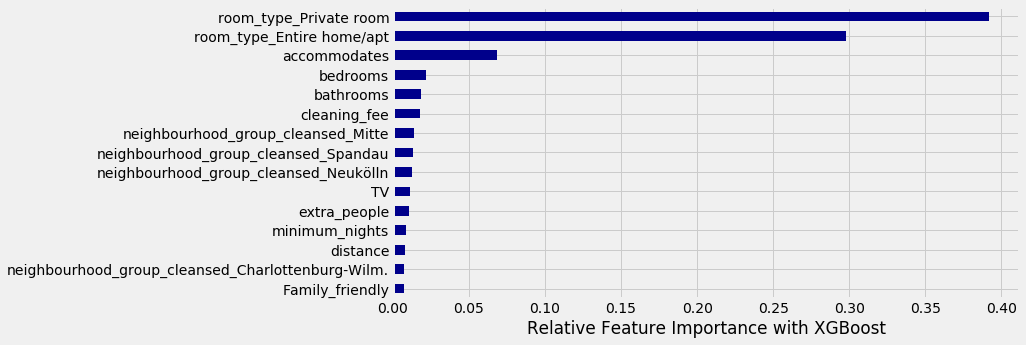

In [69]:
feat_importances = pd.Series(booster.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkblue', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost')
plt.show()